In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from bambi import Model, Prior
import pymc3 as pm

In [2]:
root = "../data/"
survDat = pd.concat([pd.read_csv(root + "cleanSurvBefore10s.csv"),
                     pd.read_csv(root + "cleanSurv10s.csv")],
                     ignore_index=True)

In [4]:
survDat.head()

,sitecode,sitename,year,weight,stratum,PSU,age,sex,grade,race4,...,qcigschool,qchewtobschool,qalcoholschool,qmarijuanaschool,qcurrentcocaine,qgenderexp,qtaughtHIV,qmusclestrength,qcurrentasthma,qtransgender
0,NYI,"Borough of Manhattan, NY (NYI)",2007,3.7107,49,2,5.0,1.0,2.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN
1,NYI,"Borough of Manhattan, NY (NYI)",2007,3.8955,49,2,5.0,1.0,4.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2,NYI,"Borough of Manhattan, NY (NYI)",2007,29.5199,14,2,5.0,1.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,NYI,"Borough of Manhattan, NY (NYI)",2007,29.5199,14,2,5.0,1.0,3.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
4,NYI,"Borough of Manhattan, NY (NYI)",2007,29.5199,14,2,5.0,1.0,3.0,3.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN


In [3]:
# These are the categories of the questions
carRiskqs = ["q8", "q9", "q10", "q11"]
violenceqs = ["q12", "q13", "q14", "q15",
              "q16", "q17", "q18"]
sexqs = ["q19", "q20", "q21", "q22", "q58", "q59",
         "q60", "q61", "q62", 
         "q63", "q64", "qtaughtHIV"]
bullyqs = ["q23", "q24", "qbullygay"]
suicideqs = ["q25", "q26", "q27", 
             "q28", "q29"]
drugqs = ["q30", "q32", "q33",
          "q38", "q40", "q41",
          "q45", "q46", "q47",
          "q50", "q51", "q52",
          "q53", "q54", "q55",
          "q56", "q57", "qcigschool",
          "qalcoholschool", "qmarijuanaschool",
          'q31', 'q34', 'q35',
          'q36', 'q37', 'q42', 
          'q43', 'q44', 'q48',
          'q49', "qchewtobschool",
          "qcurrentcocaine"]
selfqs = ["q65", "q66", "q67",
          "q68", "q89", "qnowt",
          "qnobese", "bmipct", "bmi",
          "sexpart", "sexpart2", "sexid",
          "sexid2", "stheight", "stweight",
          "race4", "race7", "sex",
          "age", "grade", "qgenderexp",
          "qmusclestrength", "qcurrentasthma",
          "qtransgender"] 
selfHealthqs = ["q69", "q70", "q71",
                "q72", "q73", "q74",
                "q76", "q79", "q81",
                "q82", "q87", 'q75',
                'q77', 'q78', 'q80',
                'q84', 'q86', 'q88'] # may want to move some of these to sexqs
riskqs = ["qbikehelmet", "qpropertydamage"]

listOfQList = [carRiskqs, violenceqs, sexqs,
               suicideqs, drugqs, selfqs,
               selfHealthqs, riskqs, bullyqs]
listOfQListName = ["carRiskqs", "violenceqs", "sexqs",
                   "suicideqs", "drugqs", "selfqs",
                   "selfHealthqs", "riskqs", "bullyqs"]

In [4]:
def clean_data(data, year, outcome_qs, input_qs, response_threshold ):
    new_data = data[data["year"] == year].copy()
    new_data["age"] = new_data["age"] + 12
    new_data = new_data[~new_data[outcome_qs].isna().all(axis=1)]

    all_qs = [x for l in input_qs for x in l]
    qs_response_rate = new_data[all_qs].isna().sum() / len(new_data)
    high_response_qs = np.where(qs_response_rate <= (1 - response_threshold))
    high_response_qs = qs_response_rate.index[high_response_qs]

    new_data = new_data.dropna(subset=high_response_qs)
    #print(carRiskScore(new_data).head())
    new_data["car_risk_score"] = carRiskScore(new_data)

    high_response_qs = np.setdiff1d(high_response_qs, outcome_qs)
    new_data = new_data[["car_risk_score"] + list(high_response_qs) + ["sitecode"]]
    print(new_data.shape)
    
    return new_data

In [5]:
def carRiskScore(dat):
    carRiskqs = ["q8", "q9"]
    q8Scores = {1.0 : 8, 2.0 : 5, 3.0 : 3, 4.0 : 1, 5.0 : 0}
    q9Scores = {1.0 : 0, 2.0 : 3, 3.0 : 5, 4.0 : 7, 5.0 : 10}
    #q10Scores = {1.0 : 0, 2.0 : 0, 3.0 : 4, 4.0 : 6, 5.0 : 8, 6.0 : 10}
    #q11Scores = {1.0 : 0, 2.0 : 0, 3.0 : 2, 4.0 : 3, 5.0 : 5, 6.0 : 7, 7.0 : 8, 8.0 : 10}
    carRiskScores = {"q8" : q8Scores, "q9" : q9Scores,}
    saturatedScore = sum([max(carRiskScores[q].values()) for q in carRiskScores.keys()])
    
    return 1000*(dat[carRiskqs].apply(lambda col : col.replace(carRiskScores[col.name]))
                               .sum(axis=1)
                               .div(saturatedScore))

In [6]:
dat_2005 = clean_data(survDat, 2005, carRiskqs, listOfQList, .9)
dat_2007 = clean_data(survDat, 2007, carRiskqs, listOfQList, .9)
dat_2009 = clean_data(survDat, 2009, carRiskqs, listOfQList, .9)

(20595, 44)
(20811, 53)
(24173, 41)


In [7]:
dat_2005.head()

,car_risk_score,age,bmi,bmipct,grade,q12,q13,q15,q16,q17,...,qmarijuanaschool,qnobese,qnowt,qpropertydamage,race4,race7,sex,stheight,stweight,sitecode
122833,166.666667,13.0,22.401235,89.512236,1.0,1.0,1.0,1.0,3.0,1.0,...,1.0,2.0,1.0,1.0,2.0,3.0,2.0,1.80,72.58,CH
122834,0.000000,15.0,29.518950,97.827183,1.0,3.0,1.0,2.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.96,113.40,CH
122836,222.222222,15.0,19.041156,43.184776,1.0,1.0,1.0,1.0,3.0,4.0,...,1.0,2.0,2.0,3.0,2.0,3.0,2.0,1.78,60.33,CH
122839,333.333333,15.0,19.470395,49.891675,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,2.0,2.0,1.0,2.0,3.0,2.0,1.78,61.69,CH
122840,0.000000,15.0,22.045828,78.873273,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,2.0,2.0,1.0,4.0,7.0,2.0,1.78,69.85,CH


In [214]:
dat_2005.to_csv("../data/data_05.csv")
dat_2007.to_csv("../data/data_07.csv")
dat_2009.to_csv("../data/data_09.csv")


In [58]:
d = dat_2005.sample(200)
d["car_risk_score"] = np.log(d["car_risk_score"] + 1)

In [65]:
var_list = ["age", "bmi", "q12", "q13"]
priors = {x:Prior("Normal", mu=1, sigma=1) for x in var_list}
priors["alpha"] = Prior("Normal", mu=1, sigma=1)
priors

{'age': Normal(mu: 1, sigma: 1),
 'bmi': Normal(mu: 1, sigma: 1),
 'q12': Normal(mu: 1, sigma: 1),
 'q13': Normal(mu: 1, sigma: 1),
 'alpha': Normal(mu: 1, sigma: 1)}

In [66]:
model = Model("car_risk_score ~ age + bmi + q12 + q13", d, dropna=True, family="gamma", priors=priors)
model

Formula: car_risk_score ~ age + bmi + q12 + q13
Family name: Gamma
Link: inverse
Observations: 200
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5)
    age ~ Normal(mu: 1, sigma: 1)
    bmi ~ Normal(mu: 1, sigma: 1)
    q12 ~ Normal(mu: 1, sigma: 1)
    q13 ~ Normal(mu: 1, sigma: 1)

  Auxiliary parameters
    alpha ~ Normal(mu: 1, sigma: 1)

In [67]:
results = model.fit()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Intercept': array([0.]), 'age': array([1.]), 'bmi': array([1.]), 'q12': array([1.]), 'q13': array([1.]), 'car_risk_score_alpha': array(1.)}

Initial evaluation results:
Intercept              -1.84
age                    -0.92
bmi                    -0.92
q12                    -0.92
q13                    -0.92
car_risk_score_alpha   -0.92
car_risk_score          -inf
Name: Log-probability of test_point, dtype: float64

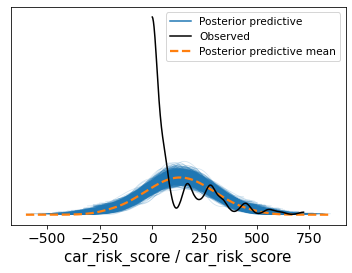

In [50]:
posterior_predictive = model.predict(results, kind="pps", draws=500)
_ = az.plot_ppc(results)

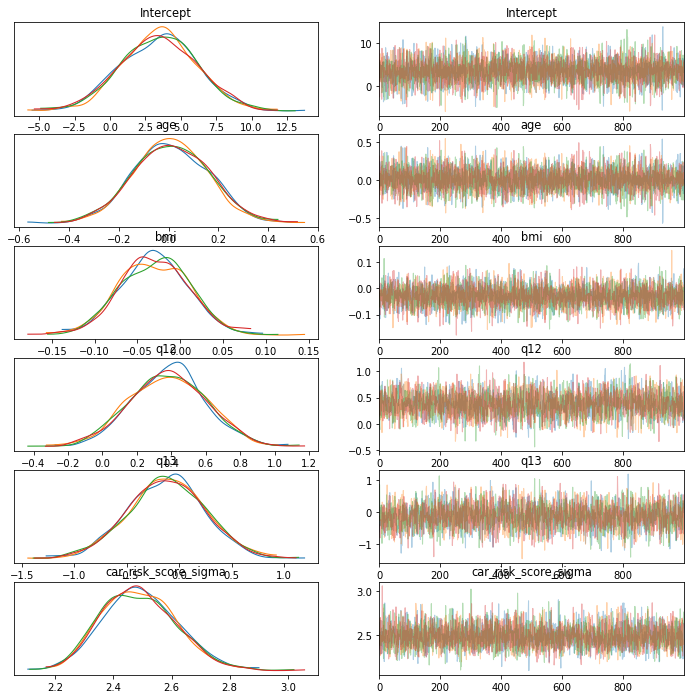

In [46]:
_ = az.plot_trace(results, compact=False)

In [203]:
d = dat_2005.sample(2000, random_state=551)
d["car_risk_score"] = d["car_risk_score"] + 1
county_idxs, counties = pd.factorize(d["sitecode"])
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [204]:


with pm.Model(coords=coords) as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")

    # Define priors
    #sigma = pm.Gamma("sigma", alpha=.01, beta=.01)
    intercept = pm.Normal("Intercept", 0, sigma=.001, dims="county")
    X = d.drop(["car_risk_score", "sitecode"], axis=1)
    beta = pm.Normal("beta", 1, sigma=10, shape=X.shape[1])

    # Define likelihood
    likelihood = pm.Gamma("y", mu=intercept[county_idx] + pm.math.dot(X, beta), sigma=100, observed=d["car_risk_score"], dims="obs_id")

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #trace = pm.sample(3000, return_inferencedata=True)

    #pm.sample_posterior_predictive(trace, var_names=["x"])

In [205]:
with model:
    trace = pm.sample(3000, return_inferencedata=True, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, Intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 173 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


In [206]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])

In [194]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [212]:
y_pred = ppc["y"].ravel()
(y_pred > 100).sum() / y_pred.shape[0] * 100

22.487279166666667

In [213]:
(d["car_risk_score"] > 100).sum() / d.shape[0] * 100

39.35

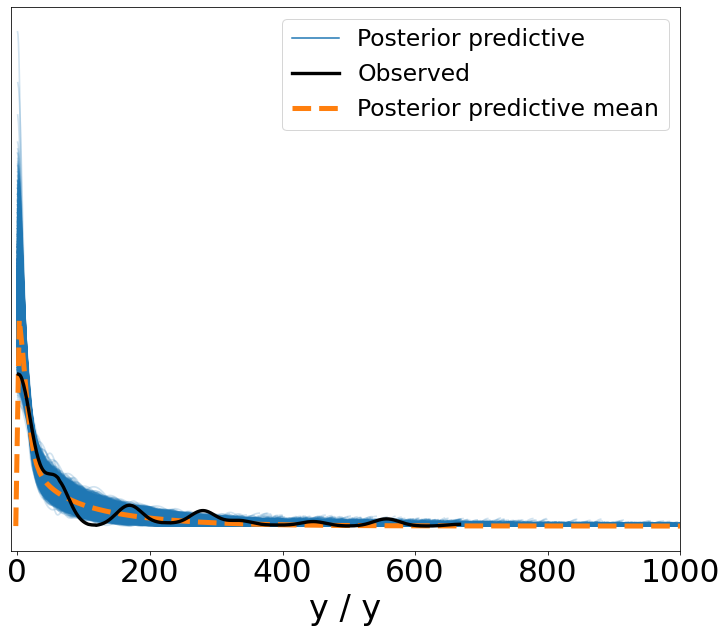

In [181]:
ax = az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(12, 10))
_ = ax.set_xlim((-10, 1000))

In [159]:
trace["posterior"]["beta"].mean(axis=1).mean(axis=0)

<xarray.DataArray 'beta' (beta_dim_0: 42)>
array([ 0.86426885,  1.64964469, -0.05040337, -3.06470718,  1.3519464 ,
       -1.32424196, -1.7849474 , -0.27879243,  1.72470987, -2.38115652,
       -0.45928833,  4.03823322, -0.30091718, -1.00710227, -0.63182755,
        4.2679917 ,  0.5095266 ,  0.13699573,  3.36658279, -0.62473338,
        1.36567123, -1.37158919, -2.87267702, -1.16186857, -0.04054701,
       -2.92436368, -0.02984308,  0.24887973, -1.30279307,  1.19482233,
       -4.36897743, -1.38950566, -1.06843798, -1.62273433,  7.22091518,
        3.42971113,  0.06901934,  1.07676881, -0.70595103,  1.30918729,
       12.89093532, -0.25034331])
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41

In [188]:
trace["posterior"]["Intercept"].mean(axis=1).mean(axis=0)

<xarray.DataArray 'Intercept' (county: 16)>
array([ 5.87145201e-06, -1.37136514e-05, -1.80846695e-05,  1.14307585e-06,
       -2.82829741e-05,  9.92576246e-06,  5.42971530e-06,  3.05813308e-06,
        1.64730564e-06, -1.66415165e-06,  5.23334320e-07, -3.57250896e-06,
       -2.68450013e-06, -1.07884277e-05, -8.11812710e-07,  2.48618489e-05])
Coordinates:
  * county   (county) object 'CH' 'FT' 'LO' 'NO' 'NYC' ... 'SB' 'NYH' 'NYJ' 'OL'

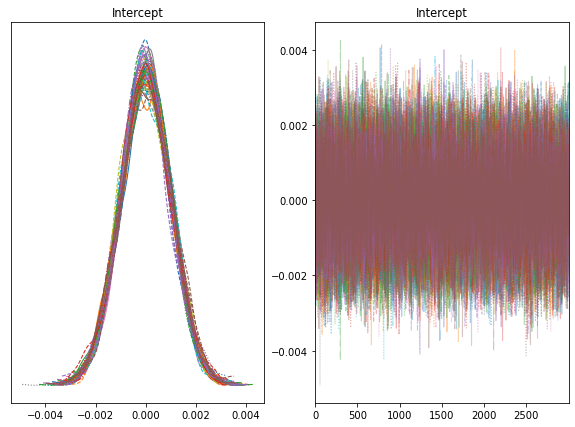

In [185]:
_ = az.plot_trace(trace["posterior"]["Intercept"], figsize=(10, 7))

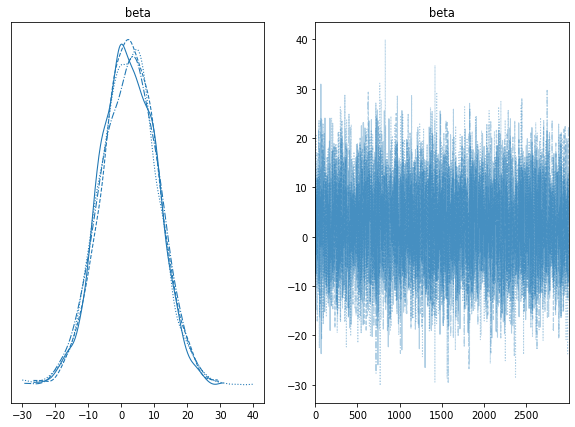

In [182]:
_ = az.plot_trace(trace["posterior"]["beta"][:,:,34], figsize=(10, 7))